## Modeling Process

I will be using a keras library 

Using a pretrained EfficentNet model 

#### Imports

In [1]:
import pandas as pd
import numpy as np
import datetime as datetime
import matplotlib.pyplot as plt
import glob
import os
import tensorflow as tf
import json
from PIL import Image

In [2]:
from tensorflow import keras

from keras import applications
from keras import callbacks
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization,Activation,Dropout, Flatten
from tensorflow.keras.optimizers import Adam 

from tensorflow.keras.applications.efficientnet import EfficientNetB0 

from keras.preprocessing.image import ImageDataGenerator

### Testing Data

#### Setting up Paths & Directories for Testing Data

In [3]:
TEST_PATH = 'Data/Test/'

In [4]:
test_images_df = pd.read_csv('test_dir_df')
test_images_df.drop(columns=['Unnamed: 0'], inplace=True)
test_images_df.head()

,file_name,id,category_id
0,inaturalist_2018/Mammalia/4070/1d411dee89eb912...,98,150
1,inaturalist_2018/Aves/3832/c810190332ee99ffd5d...,204,563
2,inaturalist_2018/Mammalia/4097/36fcaf8dc563eb1...,261,133
3,inaturalist_2018/Mammalia/4079/569ade1c2d0c46c...,412,422
4,inaturalist_2018/Mammalia/4082/8bc7da4af86153c...,508,371


In [5]:
test_images_df['category_id'].value_counts()

377    1000
378    1000
564     900
14      294
371     233
       ... 
162      11
320      10
40       10
101      10
113       8
Name: category_id, Length: 61, dtype: int64

#### Setting up Paths & Directories for Training Data

In [6]:
TRAIN_PATH = 'Data/train/' ##7655 images

In [7]:
train_df = pd.read_csv('directory_df')

In [8]:
train_df.head()

,Unnamed: 0,file_name,height,width,id,image_id,category_id
0,0,inaturalist_2017/Mammalia/Papio anubis/df40033...,533,800,94343,94343,78
1,1,inaturalist_2017/Mammalia/Papio anubis/3b3aa62...,533,800,94344,94344,78
2,2,inaturalist_2017/Mammalia/Papio anubis/8ae2d15...,601,800,94345,94345,78
3,3,inaturalist_2017/Mammalia/Papio anubis/9e58e4f...,533,800,94347,94347,78
4,4,inaturalist_2017/Mammalia/Papio anubis/5a19154...,533,800,94348,94348,78


In [9]:
train_df.drop(columns=['Unnamed: 0'], inplace=True)

train_df.drop(columns=['height', 'width','image_id'], inplace=True)

In [10]:
train_df

,file_name,id,category_id
0,inaturalist_2017/Mammalia/Papio anubis/df40033...,94343,78
1,inaturalist_2017/Mammalia/Papio anubis/3b3aa62...,94344,78
2,inaturalist_2017/Mammalia/Papio anubis/8ae2d15...,94345,78
3,inaturalist_2017/Mammalia/Papio anubis/9e58e4f...,94347,78
4,inaturalist_2017/Mammalia/Papio anubis/5a19154...,94348,78
...,...,...,...
7650,inaturalist_2017/Aves/Aramus guarauna/8f21eeeb...,665476,570
7651,inaturalist_2017/Aves/Aramus guarauna/e74852d0...,665477,570
7652,inaturalist_2017/Aves/Aramus guarauna/394d3822...,665479,570
7653,inaturalist_2017/Aves/Aramus guarauna/23893b27...,665480,570


In [11]:
train_df['category_id'].nunique()

42

In [12]:
## had to make the category_id column as type string in order to pass through 
## the image data generator
train_df['category_id'] = train_df['category_id'].astype('str')

In [13]:
test_images_df['category_id'] = test_images_df['category_id'].astype('str')

#### Creating a subset of data to work with

In [14]:
train_df['category_id'].value_counts()

378    2145
377    1476
564    1311
14      406
371     364
240     191
8       149
657     137
570     118
385     115
90      104
563      90
6        71
111      71
268      58
96       46
110      44
114      42
322      39
568      39
3        39
112      38
103      37
122      36
374      35
41       35
120      35
24       33
267      33
166      32
310      31
104      31
245      31
242      28
78       27
72       24
108      23
102      21
296      20
130      20
372      16
83       14
Name: category_id, dtype: int64

#### Training subset

In [15]:
lst = ['8', '657', '570', '385']

In [16]:
subset_df = train_df.loc[train_df['category_id'].isin(lst), : ].copy()

In [17]:
subset_df['category_id'] = subset_df['category_id'].map({ val:str(i) for i,val in enumerate(lst)})

In [18]:
subset_df['category_id'].value_counts()

0    149
1    137
2    118
3    115
Name: category_id, dtype: int64

#### Testing subset

In [19]:
lst = ['8', '657', '570', '385']

In [20]:
subset_test_df = test_images_df.loc[test_images_df['category_id'].isin(lst), : ].copy()

In [21]:
subset_test_df['category_id'] = subset_test_df['category_id'].map({ val:str(i) for i,val in enumerate(lst)})

In [22]:
subset_test_df['category_id'].value_counts()

1    92
2    86
0    86
3    85
Name: category_id, dtype: int64

In [23]:
subset_test_df.head()

,file_name,id,category_id
8,inaturalist_2018/Aves/3200/88088cdadc00f08b0c8...,591,2
17,inaturalist_2018/Mammalia/4075/ffb376615bfc2b4...,1142,0
20,inaturalist_2018/Aves/3730/7826126a17dd37045cf...,1340,1
31,inaturalist_2018/Aves/3730/ac2434cc227e63f4e79...,2016,1
45,inaturalist_2018/Aves/3730/23c0cd71cc867c46c57...,3855,1


#### Image Data Generator

This ImageDataGenerator class lets you specify which agumentations you want done for training/validation set of images. We will scale the data inside this generator

We will agument the training data but not agument the testing data. 

In [23]:
## when shifting by 20% there is space left over 
## you can fill this extra space by using fill_mode and 
## specifiying what you want to fill it with

In [24]:
train_data_generator = ImageDataGenerator(
    rescale = 1/255,
    validation_split = 0.10,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range=0.2,
    shear_range= 0.2,
    zoom_range= 0.2,
    horizontal_flip=True,
    fill_mode='reflect',
    brightness_range=(0.5,1.5) ## anything above one makes it brighter, below 1 is darker, 1 is the same brightness

)

In [25]:
train_generator = train_data_generator.flow_from_dataframe(
    dataframe = subset_df,
    directory = TRAIN_PATH,
    x_col = 'file_name',
    y_col = 'category_id',
    target_size = (224,224),
    subset = 'training',
    batch_size = 8,
    shuffle = True,
    class_mode= 'sparse')



val_generator = train_data_generator.flow_from_dataframe(
    dataframe = subset_df,
    directory = TRAIN_PATH,
    x_col = 'file_name',
    y_col = 'category_id',
    target_size=(224,224),
    subset = 'validation',
    batch_size = 8,
    shuffle = True,
    class_mode= 'sparse'

)

## using sparse as class mode because I have multi-label classifications
## there are 41 categories in complete dataset
## when using sparse as class_mode; y_column must be strings
## if x_col specifies direct path to images then you set directory equal to None or else specify directory path

Found 468 validated image filenames belonging to 4 classes.
Found 51 validated image filenames belonging to 4 classes.


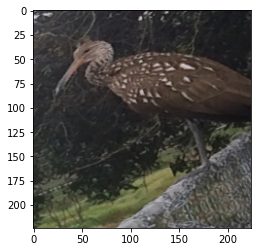

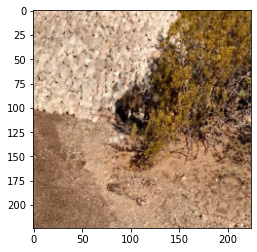

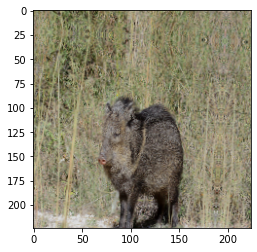

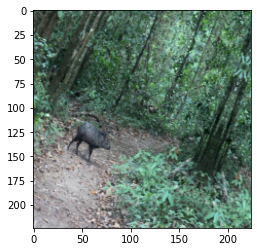

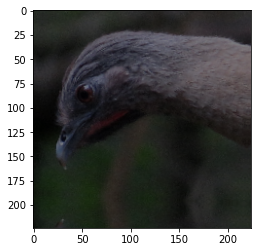

In [28]:
for _ in range(5):
    image,label = train_generator.next()
    #print(image.shape)
    plt.imshow(image[0])
    plt.show()

In [132]:
efficient_net = EfficientNetB0(
    weights='imagenet',
    input_shape=(224,224,3),
    include_top=False,
    pooling='max',
    drop_connect_rate = 0.2
    
)

model = Sequential()
efficient_net.trainable = False
model.add(efficient_net)
model.add(tf.keras.layers.BatchNormalization())



model.add(Dense(units = 4, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 1280)              4049571   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1280)              5120      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 5124      
Total params: 4,059,815
Trainable params: 7,684
Non-trainable params: 4,052,131
_________________________________________________________________


In [133]:
model.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [134]:
history = model.fit(
    train_generator,
    epochs = 20,
    steps_per_epoch = train_generator.n//train_generator.batch_size,
    validation_data = val_generator,
    validation_steps = val_generator.n//val_generator.batch_size,
    
)

Epoch 1/20


2021-11-17 11:54:51.736143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - ETA: 0s - loss: 5.5023 - accuracy: 0.2543

2021-11-17 11:54:59.533359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - 10s 137ms/step - loss: 5.5023 - accuracy: 0.2543 - val_loss: 0.0194 - val_accuracy: 1.0000
Epoch 2/20
58/58 [==============================] - 7s 113ms/step - loss: 3.3750 - accuracy: 0.2826 - val_loss: 17.6429 - val_accuracy: 0.0000e+00
Epoch 3/20
58/58 [==============================] - 6s 109ms/step - loss: 3.2834 - accuracy: 0.2761 - val_loss: 0.4674 - val_accuracy: 1.0000
Epoch 4/20
58/58 [==============================] - 6s 110ms/step - loss: 2.5720 - accuracy: 0.3196 - val_loss: 3.5836 - val_accuracy: 0.0000e+00
Epoch 5/20
58/58 [==============================] - 6s 108ms/step - loss: 2.5575 - accuracy: 0.2761 - val_loss: 2.6452 - val_accuracy: 0.0000e+00
Epoch 6/20
58/58 [==============================] - 6s 108ms/step - loss: 2.5520 - accuracy: 0.2717 - val_loss: 1.4058 - val_accuracy: 0.0000e+00
Epoch 7/20
58/58 [==============================] - 6s 108ms/step - loss: 2.1824 - accuracy: 0.2261 - val_loss: 1.2259 - val_accuracy: 0.1458

#### Notes

Above in the modeling cell; the earlier layers of this network were frozen so that the network can focus on training the newer layers with the new data. When starting out use a large learning learning rate and a small number of epochs, between 10 - 20. 

Once you have trained the new layers then you can fine tune the beginning / lower layers. This allows the lower layers to be trained with the same weights the newer layers. 

In [135]:
for layer in model.layers:
    if not isinstance(layer,tf.keras.layers.BatchNormalization):
        layer.trainable = True
  

model.compile(optimizer=Adam(learning_rate=0.00001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history2 = model.fit(
    train_generator,
    epochs = 100,
   
    steps_per_epoch = train_generator.n//train_generator.batch_size,
    validation_data = val_generator,
    validation_steps = val_generator.n//val_generator.batch_size,
    
)

Epoch 1/100


2021-11-17 11:58:11.207404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - ETA: 0s - loss: 1.3358 - accuracy: 0.3587

2021-11-17 11:58:34.832055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - 27s 348ms/step - loss: 1.3358 - accuracy: 0.3587 - val_loss: 1.7577 - val_accuracy: 0.0000e+00
Epoch 2/100
58/58 [==============================] - 16s 274ms/step - loss: 1.3009 - accuracy: 0.4022 - val_loss: 1.7991 - val_accuracy: 0.0000e+00
Epoch 3/100
58/58 [==============================] - 16s 276ms/step - loss: 1.2940 - accuracy: 0.4609 - val_loss: 1.8043 - val_accuracy: 0.0000e+00
Epoch 4/100
58/58 [==============================] - 16s 275ms/step - loss: 1.2635 - accuracy: 0.4804 - val_loss: 1.6408 - val_accuracy: 0.0000e+00
Epoch 5/100
58/58 [==============================] - 16s 278ms/step - loss: 1.2499 - accuracy: 0.5000 - val_loss: 1.5647 - val_accuracy: 0.0000e+00
Epoch 6/100
58/58 [==============================] - 16s 274ms/step - loss: 1.2269 - accuracy: 0.5413 - val_loss: 1.5239 - val_accuracy: 0.0000e+00
Epoch 7/100
58/58 [==============================] - 16s 274ms/step - loss: 1.2268 - accuracy: 0.5696 - val_loss: 1.5390 - v

In [136]:
evaluation_data_gen = ImageDataGenerator(rescale=1/255.)
eval_generator = evaluation_data_gen.flow_from_dataframe(
    dataframe = subset_df,
    directory = TRAIN_PATH,
    x_col = 'file_name',
    y_col = 'category_id',
    target_size= (224,224),
    batch_size = 1,
    shuffle = False,
    class_mode= 'sparse')

step_size_eval = eval_generator.n // eval_generator.batch_size
preds = model.predict(eval_generator, steps=step_size_eval)

Found 519 validated image filenames belonging to 4 classes.


2021-11-17 12:26:17.449579: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [137]:
model.evaluate(eval_generator)

519/519 [==============================] - 10s 19ms/step - loss: 0.2161 - accuracy: 0.9615


[0.2160966545343399, 0.9614643454551697]

In [138]:
test_data_generator = ImageDataGenerator(
    rescale = 1/255
)

test_generator = test_data_generator.flow_from_dataframe(
    dataframe= subset_test_df,
    directory= TEST_PATH,
    x_col = 'file_name',
    y_col = 'category_id',
    target_size= (224, 224),
    batch_size= 1,
    shuffle=False,
    class_mode='sparse'

)

step_size_test = test_generator.n // test_generator.batch_size
preds_test = model.predict(test_generator, steps=step_size_test)
model.evaluate(test_generator)

Found 349 validated image filenames belonging to 4 classes.
349/349 [==============================] - 6s 18ms/step - loss: 0.2218 - accuracy: 0.9542


[0.22182150185108185, 0.9541547894477844]

In [152]:
preds_test_df = pd.DataFrame({ 
    'preds': np.argmax(preds_test, axis=1),
    'label': test_generator.classes,
    'file_name': test_generator.filenames
})

In [153]:
preds_test_df[preds_test_df['preds']!= preds_test_df['label']]

,preds,label,file_name
8,2,3,inaturalist_2018/Aves/3175/0b7af1e8b13514a7579...
23,1,3,inaturalist_2018/Aves/3175/8cc14e93362f1d1a276...
38,1,3,inaturalist_2018/Aves/3175/6d7d211a4995d5e2f70...
41,2,3,inaturalist_2018/Aves/3175/f0ee8c03adb9e6b6b4d...
44,2,3,inaturalist_2018/Aves/3175/1f1ea7a69c8d59f9e9c...
45,2,3,inaturalist_2018/Aves/3175/71cc33c7bbc2c289ab6...
115,2,3,inaturalist_2018/Aves/3175/357579ad0b7dad1308a...
145,1,3,inaturalist_2018/Aves/3175/d0c33ce39ded3afef85...
171,2,3,inaturalist_2018/Aves/3175/55b87afb39069ae666b...
196,0,3,inaturalist_2018/Aves/3175/01a72d4a85e6db769f5...


In [154]:
preds_test_df[ preds_test_df['preds'] == preds_test_df['label']]['label'].value_counts()

1    90
0    86
2    85
3    72
Name: label, dtype: int64

In [155]:
preds_test_df[ preds_test_df['preds'] != preds_test_df['label']]['label'].value_counts()

3    13
1     2
2     1
Name: label, dtype: int64

In [156]:
preds_df = pd.DataFrame({ 
    'preds': np.argmax(preds, axis=1),
    'label': eval_generator.classes
})

In [157]:
preds_df[preds_df['preds'] == preds_df['label']]

,preds,label
1,3,3
3,3,3
4,3,3
5,3,3
6,3,3
...,...,...
514,2,2
515,2,2
516,2,2
517,2,2


In [158]:
preds_df[ preds_df['preds'] == preds_df['label']]['label'].value_counts()

0    149
1    137
2    116
3     97
Name: label, dtype: int64

In [159]:
preds_df[ preds_df['preds'] != preds_df['label']]['label'].value_counts()

3    18
2     2
Name: label, dtype: int64

#### Looking at the Inncorrectly Classified Images for Test Data

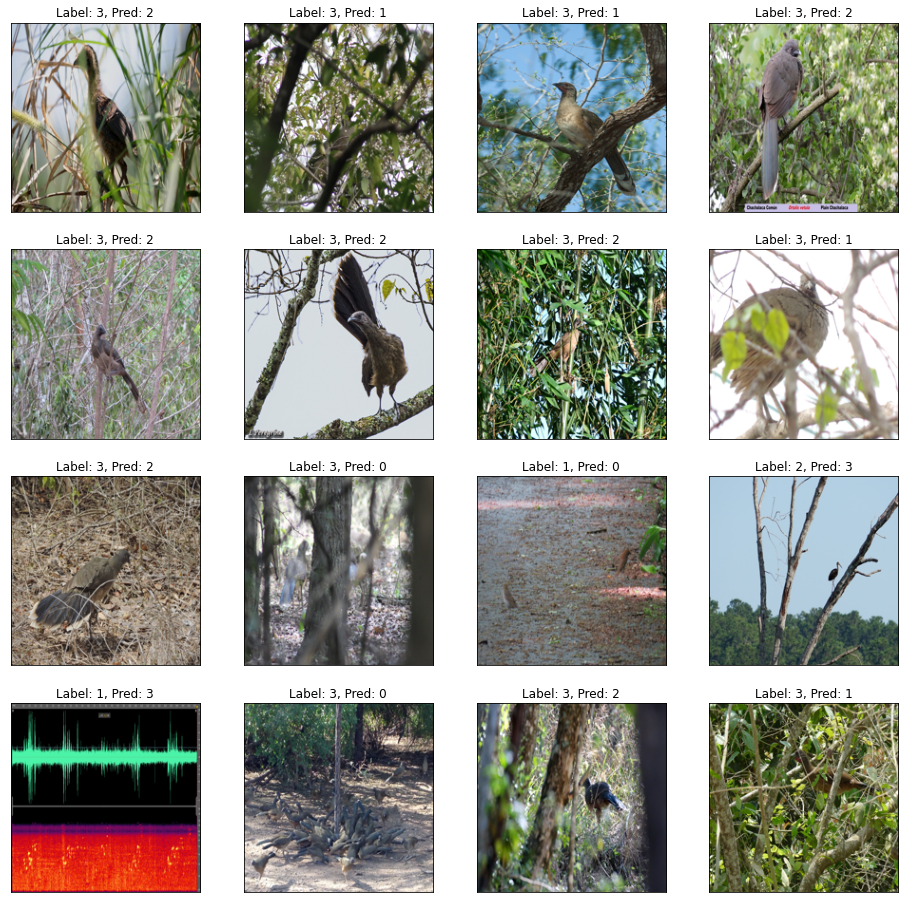

In [162]:
fig = plt.figure(figsize=(16, 16))
error_path = 'Data/Test/'
incorrect_preds = preds_test_df[ preds_test_df['preds'] != preds_test_df['label']].copy()

for i,idx in enumerate(incorrect_preds.index[:21]):
    im_path = error_path + incorrect_preds.loc[idx,'file_name']
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    ax.set_title(f"Label: {incorrect_preds.loc[idx,'label']}, Pred: {incorrect_preds.loc[idx,'preds']}")
    im = Image.open(im_path)
    im = im.resize((200,200))
    plt.imshow(im)